In [83]:
from pycocotools.coco import COCO
import numpy as np
import skimage.io as io
from skimage.color import gray2rgb
import random
import os
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from matplotlib.path import Path
import skimage.data

### For visualizing the outputs ###
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline

In [3]:
dataDir='data'
dataType='val2017'
annFile='{}/annotations/instances_{}.json'.format(dataDir,dataType)

# Initialize the COCO api for instance annotations
coco=COCO(annFile)

# Load the categories in a variable
catIDs = coco.getCatIds()
cats = coco.loadCats(catIDs)

print(cats)

loading annotations into memory...
Done (t=1.44s)
creating index...
index created!
[{'supercategory': 'person', 'id': 1, 'name': 'person'}, {'supercategory': 'vehicle', 'id': 2, 'name': 'bicycle'}, {'supercategory': 'vehicle', 'id': 3, 'name': 'car'}, {'supercategory': 'vehicle', 'id': 4, 'name': 'motorcycle'}, {'supercategory': 'vehicle', 'id': 5, 'name': 'airplane'}, {'supercategory': 'vehicle', 'id': 6, 'name': 'bus'}, {'supercategory': 'vehicle', 'id': 7, 'name': 'train'}, {'supercategory': 'vehicle', 'id': 8, 'name': 'truck'}, {'supercategory': 'vehicle', 'id': 9, 'name': 'boat'}, {'supercategory': 'outdoor', 'id': 10, 'name': 'traffic light'}, {'supercategory': 'outdoor', 'id': 11, 'name': 'fire hydrant'}, {'supercategory': 'outdoor', 'id': 13, 'name': 'stop sign'}, {'supercategory': 'outdoor', 'id': 14, 'name': 'parking meter'}, {'supercategory': 'outdoor', 'id': 15, 'name': 'bench'}, {'supercategory': 'animal', 'id': 16, 'name': 'bird'}, {'supercategory': 'animal', 'id': 17, 'n

In [86]:
# Define the classes (out of the 81) which you want to see. Others will not be shown.
filterClasses = ['train']

# Fetch class IDs only corresponding to the filterClasses
catIds = coco.getCatIds(catNms=filterClasses) 
# Get all images containing the above Category IDs
imgIds = coco.getImgIds(catIds=catIds)
print("Number of images containing all the  classes:", len(imgIds))

Number of images containing all the  classes: 157


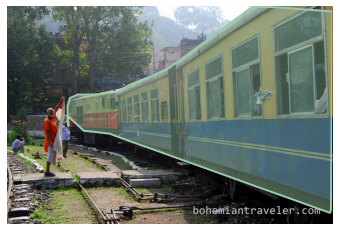

In [87]:
# load and display a random image
img = coco.loadImgs(imgIds[np.random.randint(0,len(imgIds))])[0]
I = io.imread('{}/{}/{}'.format(dataDir,dataType,img['file_name']))/255.0

plt.imshow(I)
plt.axis('off')
annIds = coco.getAnnIds(imgIds=img['id'], catIds=catIds, iscrowd=0)
anns = coco.loadAnns(annIds)
coco.showAnns(anns)

The class name is cell phone


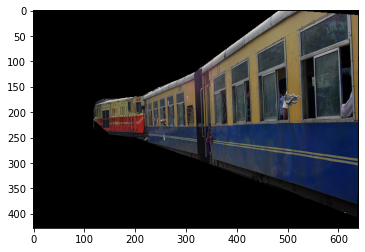

In [88]:
def getClassName(classID, cats):
    for i in range(len(cats)):
        if cats[i]['id']==classID:
            return cats[i]['name']
    return "None"
print('The class name is', getClassName(77, cats))

def segmentTo2DArray(segmentation):
    polygon = []
    for partition in segmentation:
        for x, y in zip(partition[::2], partition[1::2]):
            polygon.append((x,y))
    return polygon

def maskPixels(polygon, img):
    path = Path(polygon)
    xmin, ymin, xmax, ymax = np.asarray(path.get_extents(), dtype=int).ravel()
    x, y = np.mgrid[:img['width'], :img['height']]
    points = np.vstack((x.ravel(), y.ravel())).T
    mask = path.contains_points(points)
    path_points = points[np.where(mask)]
    img_mask = mask.reshape(x.shape).T
    return img_mask

polyVerts = segmentTo2DArray(anns[0]['segmentation'])
img_mask = maskPixels(polyVerts, img)
plt.imshow(I * img_mask[...,None])

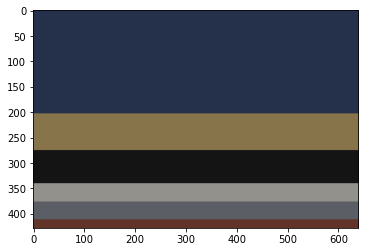

In [89]:
def getMaskColors(maskPixels):
    pixels = np.float32(maskPixels.reshape(-1, 3))
    pixels = pixels[np.all(pixels != 0, axis=1), :]
    
    n_colors = 6
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 200, .1)
    flags = cv2.KMEANS_RANDOM_CENTERS
    _, labels, palette = cv2.kmeans(pixels, n_colors, None, criteria, 10, flags)
    _, counts = np.unique(labels, return_counts=True)
    dominant = palette[np.argmax(counts)]
    return counts, palette*255.0

counts, palette = getMaskColors(I * img_mask[...,None])

indices = np.argsort(counts)[::-1]
freqs = np.cumsum(np.hstack([[0], counts[indices]/counts.sum()]))
rows = np.int_((I * img_mask[...,None]).shape[0]*freqs)

dom_patch = np.zeros(shape=(I * img_mask[...,None]).shape, dtype=np.uint8)
for i in range(len(rows) - 1):
    dom_patch[rows[i]:rows[i + 1], :, :] += np.uint8(palette[indices[i]])
    
plt.imshow(dom_patch)
# ax1.set_title('Dominant colors')
# ax1.axis('off')
# plt.show(ax1)

In [84]:
from PIL import Image

def getSegmentedMasks(filterClasses):
    # Returns single object annotation with background removed
    dataDir = 'data'
    dataType = 'val2017'
    catIds = coco.getCatIds(catNms=filterClasses)
    imgIds = coco.getImgIds(catIds=catIds)

    if len(imgIds) > 500:
        imgIds = random.sample(imgIds, 500)
    imgs = coco.loadImgs(imgIds)

    segmented_masks = []
    for img in imgs:
        # Load image
        loaded_img = io.imread('{}/{}/{}'.format(dataDir, dataType, img['file_name']), as_gray=False) / 255.0
        if len(loaded_img.shape) == 2:
            loaded_img = skimage.color.gray2rgb(loaded_img)


        # Get annotation
        annIds = coco.getAnnIds(imgIds=img['id'], catIds=catIds, iscrowd=0)
        anns = coco.loadAnns(annIds)

        for ann in anns:
            polyVerts = segmentTo2DArray(ann['segmentation'])
            img_mask = maskPixels(polyVerts, img)
            segmented_masks.append(loaded_img * img_mask[..., None])
    return segmented_masks


def stichImages(im_list, interpolation=cv2.INTER_CUBIC):
    w_min = min(im.shape[1] for im in im_list)
    im_list_resize = [cv2.resize(im, (w_min, int(im.shape[0] * w_min / im.shape[1])), interpolation=interpolation)
                      for im in im_list]
    return np.array(cv2.vconcat(im_list_resize))


# def stichImages(im_list, resample=Image.BICUBIC):
#     min_height = min((im.shape)[1] for im in im_list)
#     im_list_resize = [im.resize((int((im.shape)[0] * min_height / (im.shape)[1]), min_height),resample=resample)
#                       for im in im_list]
#     total_width = sum((im.shape)[0] for im in im_list_resize)
#     dst = Image.new('RGB', (total_width, min_height))
#     pos_x = 0
#     for im in im_list_resize:
#         dst.paste(im, (pos_x, 0))
#         pos_x += (im.shape)[0]
#     return dst


def getObjColors(image):
    n_colors = 10
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, .1)
    flags = cv2.KMEANS_RANDOM_CENTERS

    pixels = np.float32(image.reshape(-1, 3))
    pixels = pixels[np.all(pixels != 0, axis=1), :]
    _, labels, palette = cv2.kmeans(pixels, n_colors, None, criteria, 10, flags)
    _, counts = np.unique(labels, return_counts=True)

    dominant = palette[np.argmax(counts)]
    palette *= 255.0

    return counts, palette


def displayDominantColors(counts, palette):
    indices = np.argsort(counts)[::-1]   
    freqs = np.cumsum(np.hstack([[0], counts[indices]/counts.sum()]))
    rows = np.int_(640*freqs)
    dom_patch = np.zeros(shape=(400,640,3), dtype=np.uint8)
    for i in range(len(rows) - 1):
        dom_patch[rows[i]:rows[i + 1], :, :] += np.uint8(palette[indices[i]])
    return dom_patch


def getCatColors(filterClasses):
    print("--Loading object masks...")
    segmented_masks = getSegmentedMasks(filterClasses)
    print("--Stitching objects...")
    image = stichImages(segmented_masks)
    print("--Processing dominant colours...")
    counts, palette = getObjColors(image)
    color_patch = displayDominantColors(counts, palette)
    return color_patch

In [85]:
cat_colors = getCatColors(['person'])
# print(cat_colors)
plt.imshow(cat_colors)

--Loading object masks...
(427, 640, 3)
(427, 640, 1)

(480, 640, 3)
(480, 640, 1)

(480, 640, 3)
(480, 640, 1)

(480, 640, 3)
(480, 640, 1)

(480, 640, 3)
(480, 640, 1)

(480, 640, 3)
(480, 640, 1)

(480, 640, 3)
(480, 640, 1)

(480, 640, 3)
(480, 640, 1)

(480, 640, 3)
(480, 640, 1)

(480, 640, 3)
(480, 640, 1)

(480, 640, 3)
(480, 640, 1)

(480, 640, 3)
(480, 640, 1)

(480, 640, 3)
(480, 640, 1)

(480, 640, 3)
(480, 640, 1)

(480, 640, 3)
(480, 640, 1)

(480, 640, 3)
(480, 640, 1)

(480, 640, 3)
(480, 640, 1)

(480, 640, 3)
(480, 640, 1)

(480, 640, 3)
(480, 640, 1)

(480, 640, 3)
(480, 640, 1)

(480, 640, 3)
(480, 640, 1)

(329, 500, 3)
(329, 500, 1)

(329, 500, 3)
(329, 500, 1)

(329, 500, 3)
(329, 500, 1)

(375, 500, 3)
(375, 500, 1)

(375, 500, 3)
(375, 500, 1)

(375, 500, 3)
(375, 500, 1)

(375, 500, 3)
(375, 500, 1)

(375, 500, 3)
(375, 500, 1)

(375, 500, 3)
(375, 500, 1)

(375, 500, 3)
(375, 500, 1)

(375, 500, 3)
(375, 500, 1)

(640, 427, 3)
(640, 427, 1)

(612, 612, 3)
(61

(375, 500, 3)
(375, 500, 1)

(640, 427, 3)
(640, 427, 1)

(428, 640, 3)
(428, 640, 1)

(428, 640, 3)
(428, 640, 1)

(480, 640, 3)
(480, 640, 1)

(480, 640, 3)
(480, 640, 1)

(480, 640, 3)
(480, 640, 1)

(480, 640, 3)
(480, 640, 1)

(480, 640, 3)
(480, 640, 1)

(427, 640, 3)
(427, 640, 1)

(427, 640, 3)
(427, 640, 1)

(427, 640, 3)
(427, 640, 1)

(427, 640, 3)
(427, 640, 1)

(427, 640, 3)
(427, 640, 1)

(427, 640, 3)
(427, 640, 1)

(427, 640, 3)
(427, 640, 1)

(427, 640, 3)
(427, 640, 1)

(427, 640, 3)
(427, 640, 1)

(427, 640, 3)
(427, 640, 1)

(427, 640, 3)
(427, 640, 1)

(427, 640, 3)
(427, 640, 1)

(427, 640, 3)
(427, 640, 1)

(640, 480, 3)
(640, 480, 1)

(375, 500, 3)
(375, 500, 1)

(423, 640, 3)
(423, 640, 1)

(423, 640, 3)
(423, 640, 1)

(423, 640, 3)
(423, 640, 1)

(423, 640, 3)
(423, 640, 1)

(423, 640, 3)
(423, 640, 1)

(423, 640, 3)
(423, 640, 1)

(423, 640, 3)
(423, 640, 1)

(423, 640, 3)
(423, 640, 1)

(423, 640, 3)
(423, 640, 1)

(423, 640, 3)
(423, 640, 1)

(423, 640, 3)


(500, 328, 3)
(500, 328, 1)

(500, 328, 3)
(500, 328, 1)

(427, 640, 3)
(427, 640, 1)

(427, 640, 3)
(427, 640, 1)

(427, 640, 3)
(427, 640, 1)

(427, 640, 3)
(427, 640, 1)

(427, 640, 3)
(427, 640, 1)

(427, 640, 3)
(427, 640, 1)

(427, 640, 3)
(427, 640, 1)

(427, 640, 3)
(427, 640, 1)

(427, 640, 3)
(427, 640, 1)

(427, 640, 3)
(427, 640, 1)

(427, 640, 3)
(427, 640, 1)

(427, 640, 3)
(427, 640, 1)

(427, 640, 3)
(427, 640, 1)

(479, 640, 3)
(479, 640, 1)

(479, 640, 3)
(479, 640, 1)

(479, 640, 3)
(479, 640, 1)

(479, 640, 3)
(479, 640, 1)

(480, 640, 3)
(480, 640, 1)

(480, 640, 3)
(480, 640, 1)

(376, 500, 3)
(376, 500, 1)

(478, 640, 3)
(478, 640, 1)

(478, 640, 3)
(478, 640, 1)

(430, 640, 3)
(430, 640, 1)

(333, 500, 3)
(333, 500, 1)

(333, 500, 3)
(333, 500, 1)

(333, 500, 3)
(333, 500, 1)

(333, 500, 3)
(333, 500, 1)

(480, 640, 3)
(480, 640, 1)

(480, 640, 3)
(480, 640, 1)

(480, 640, 3)
(480, 640, 1)

(480, 640, 3)
(480, 640, 1)

(480, 640, 3)
(480, 640, 1)

(480, 640, 3)


(640, 427, 3)
(640, 427, 1)

(640, 427, 3)
(640, 427, 1)

(640, 427, 3)
(640, 427, 1)

(640, 427, 3)
(640, 427, 1)

(480, 640, 3)
(480, 640, 1)

(480, 640, 3)
(480, 640, 1)

(480, 640, 3)
(480, 640, 1)

(480, 640, 3)
(480, 640, 1)

(480, 640, 3)
(480, 640, 1)

(480, 640, 3)
(480, 640, 1)

(480, 640, 3)
(480, 640, 1)

(480, 640, 3)
(480, 640, 1)

(480, 640, 3)
(480, 640, 1)

(480, 640, 3)
(480, 640, 1)

(480, 640, 3)
(480, 640, 1)

(480, 640, 3)
(480, 640, 1)

(480, 640, 3)
(480, 640, 1)

(480, 640, 3)
(480, 640, 1)

(480, 640, 3)
(480, 640, 1)

(512, 640, 3)
(512, 640, 1)

(480, 640, 3)
(480, 640, 1)

(480, 640, 3)
(480, 640, 1)

(480, 640, 3)
(480, 640, 1)

(375, 500, 3)
(375, 500, 1)

(640, 407, 3)
(640, 407, 1)

(375, 500, 3)
(375, 500, 1)

(375, 500, 3)
(375, 500, 1)

(425, 640, 3)
(425, 640, 1)

(425, 640, 3)
(425, 640, 1)

(425, 640, 3)
(425, 640, 1)

(640, 425, 3)
(640, 425, 1)

(427, 640, 3)
(427, 640, 1)

(427, 640, 3)
(427, 640, 1)

(427, 640, 3)
(427, 640, 1)

(427, 640, 3)


(480, 640, 3)
(480, 640, 1)

(480, 640, 3)
(480, 640, 1)

(480, 640, 3)
(480, 640, 1)

(480, 640, 3)
(480, 640, 1)

(480, 640, 3)
(480, 640, 1)

(640, 426, 3)
(640, 426, 1)

(640, 426, 3)
(640, 426, 1)

(609, 640, 3)
(609, 640, 1)

(609, 640, 3)
(609, 640, 1)

(609, 640, 3)
(609, 640, 1)

(609, 640, 3)
(609, 640, 1)

(609, 640, 3)
(609, 640, 1)

(609, 640, 3)
(609, 640, 1)

(609, 640, 3)
(609, 640, 1)

(426, 640, 3)
(426, 640, 1)

(426, 640, 3)
(426, 640, 1)

(426, 640, 3)
(426, 640, 1)

(426, 640, 3)
(426, 640, 1)

(426, 640, 3)
(426, 640, 1)

(426, 640, 3)
(426, 640, 1)

(426, 640, 3)
(426, 640, 1)

(427, 640, 3)
(427, 640, 1)

(427, 640, 3)
(427, 640, 1)

(427, 640, 3)
(427, 640, 1)

(427, 640, 3)
(427, 640, 1)

(427, 640, 3)
(427, 640, 1)

(334, 500, 3)
(334, 500, 1)

(427, 640, 3)
(427, 640, 1)

(427, 640, 3)
(427, 640, 1)

(427, 640, 3)
(427, 640, 1)

(480, 640, 3)
(480, 640, 1)

(480, 640, 3)
(480, 640, 1)

(418, 640, 3)
(418, 640, 1)

(427, 640, 3)
(427, 640, 1)

(640, 480, 3)


(480, 640, 3)
(480, 640, 1)

(428, 640, 3)
(428, 640, 1)

(431, 640, 3)
(431, 640, 1)

(431, 640, 3)
(431, 640, 1)

(431, 640, 3)
(431, 640, 1)

(431, 640, 3)
(431, 640, 1)

(431, 640, 3)
(431, 640, 1)

(431, 640, 3)
(431, 640, 1)

(431, 640, 3)
(431, 640, 1)

(431, 640, 3)
(431, 640, 1)

(431, 640, 3)
(431, 640, 1)

(431, 640, 3)
(431, 640, 1)

(431, 640, 3)
(431, 640, 1)

(640, 480, 3)
(640, 480, 1)

(480, 640, 3)
(480, 640, 1)

(507, 640, 3)
(507, 640, 1)

(507, 640, 3)
(507, 640, 1)

(507, 640, 3)
(507, 640, 1)

(507, 640, 3)
(507, 640, 1)

(480, 640, 3)
(480, 640, 1)

(480, 640, 3)
(480, 640, 1)

(480, 640, 3)
(480, 640, 1)

(480, 640, 3)
(480, 640, 1)

(425, 640, 3)
(425, 640, 1)

(425, 640, 3)
(425, 640, 1)

(425, 640, 3)
(425, 640, 1)

(425, 640, 3)
(425, 640, 1)

(425, 640, 3)
(425, 640, 1)

(425, 640, 3)
(425, 640, 1)

(425, 640, 3)
(425, 640, 1)

(425, 640, 3)
(425, 640, 1)

(425, 640, 3)
(425, 640, 1)

(425, 640, 3)
(425, 640, 1)

(425, 640, 3)
(425, 640, 1)

(425, 640, 3)


(480, 640, 3)
(480, 640, 1)

(480, 640, 3)
(480, 640, 1)

(480, 640, 3)
(480, 640, 1)

(480, 640, 3)
(480, 640, 1)

(480, 640, 3)
(480, 640, 1)

(480, 640, 3)
(480, 640, 1)

(480, 640, 3)
(480, 640, 1)

(480, 640, 3)
(480, 640, 1)

(480, 640, 3)
(480, 640, 1)

(480, 640, 3)
(480, 640, 1)

(480, 640, 3)
(480, 640, 1)

(480, 640, 3)
(480, 640, 1)

(480, 640, 3)
(480, 640, 1)

(480, 640, 3)
(480, 640, 1)

(480, 640, 3)
(480, 640, 1)

(480, 640, 3)
(480, 640, 1)

(480, 640, 3)
(480, 640, 1)

(480, 640, 3)
(480, 640, 1)

(480, 640, 3)
(480, 640, 1)

(480, 640, 3)
(480, 640, 1)

(480, 640, 3)
(480, 640, 1)

(399, 640, 3)
(399, 640, 1)

(457, 640, 3)
(457, 640, 1)

(457, 640, 3)
(457, 640, 1)

(457, 640, 3)
(457, 640, 1)

(457, 640, 3)
(457, 640, 1)

(480, 640, 3)
(480, 640, 1)

(480, 640, 3)
(480, 640, 1)

(480, 640, 3)
(480, 640, 1)

(480, 640, 3)
(480, 640, 1)

(480, 640, 3)
(480, 640, 1)

(375, 500, 3)
(375, 500, 1)

(375, 500, 3)
(375, 500, 1)

(375, 500, 3)
(375, 500, 1)

(375, 500, 3)


(444, 640, 3)
(444, 640, 1)

(444, 640, 3)
(444, 640, 1)

(397, 640, 3)
(397, 640, 1)

(397, 640, 3)
(397, 640, 1)

(640, 480, 3)
(640, 480, 1)

(640, 480, 3)
(640, 480, 1)

(640, 480, 3)
(640, 480, 1)

(640, 480, 3)
(640, 480, 1)

(457, 640, 3)
(457, 640, 1)

(457, 640, 3)
(457, 640, 1)

(457, 640, 3)
(457, 640, 1)

(457, 640, 3)
(457, 640, 1)

(457, 640, 3)
(457, 640, 1)

(457, 640, 3)
(457, 640, 1)

(457, 640, 3)
(457, 640, 1)

(457, 640, 3)
(457, 640, 1)

(457, 640, 3)
(457, 640, 1)

(457, 640, 3)
(457, 640, 1)

(457, 640, 3)
(457, 640, 1)

(457, 640, 3)
(457, 640, 1)

(457, 640, 3)
(457, 640, 1)

(427, 640, 3)
(427, 640, 1)

(427, 640, 3)
(427, 640, 1)

(427, 640, 3)
(427, 640, 1)

(427, 640, 3)
(427, 640, 1)

(427, 640, 3)
(427, 640, 1)

(427, 640, 3)
(427, 640, 1)

(375, 500, 3)
(375, 500, 1)

(639, 640, 3)
(639, 640, 1)

(478, 640, 3)
(478, 640, 1)

(360, 480, 3)
(360, 480, 1)

(360, 480, 3)
(360, 480, 1)

(360, 480, 3)
(360, 480, 1)

(360, 480, 3)
(360, 480, 1)

(360, 480, 3)


KeyboardInterrupt: 